In [ ]:
from dataclasses import dataclass, asdict
import re
import io
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
from google import genai
import pickle
from google.colab import drive
import datetime

In [ ]:
drive.mount('/content/drive')
# Drive can be found in 'drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
client = genai.Client(api_key='')

In [ ]:
@dataclass
class NarrowCorridorPath:
  # period to data.
  country: str
  model: str
  periods: list[tuple[int]]
  society_power: dict[tuple[int], float]
  state_power: dict[tuple[int], float]
  events_trends_prompt: dict[tuple[int], str]
  events_trends_response: dict[tuple[int], str]
  score_prompt: dict[tuple[int], str]
  score_response: dict[tuple[int], str]

In [ ]:
def period_to_text(period: tuple[int]) -> str:
  return f"{period[0]}-{period[1]}"


def get_society_state_power(response: str) -> tuple[float, float, float, float]:
  m = re.search(r"<([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+)>", response)
  if m:
    try:
      float1 = float(m.group(1))
      float2 = float(m.group(2))
      return (0, 0, float1, float2)
    except ValueError:
      raise ValueError(f"Bad format in {response}")
  else:
    m = re.search(
        r"<\s*([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+)\s*>",
        response,
    )
    if m:
      try:
        float1 = float(m.group(1))
        float2 = float(m.group(2))
        float3 = float(m.group(3))
        float4 = float(m.group(4))
        return (float1, float2, float3, float4)
      except ValueError:
        raise ValueError(f"Bad format in {response}")
    else:

      raise ValueError(f"Missing numbers in {response}")


def get_narrow_corridor(
    client: genai.Client,
    model: str = "gemini-2.0-flash",
    country: str = "Iran (Persia)",
    start_year: int = 1870,
    end_year: int = 2025,
    step_years: int = 5,
) -> NarrowCorridorPath:
  path = NarrowCorridorPath(
      country=country,
      model=model,
      periods=[],
      society_power={},
      state_power={},
      events_trends_prompt={},
      events_trends_response={},
      score_prompt={},
      score_response={},
  )

  initial_period = (start_year, start_year + step_years - 1)
  path.periods.append(initial_period)
  initial_period_text = period_to_text(initial_period)
  score_prompt = f"""
  Considering the framework proposed by Daron Acemoğlu and James A. Robinson in
  The Narrow Corridor: States, Societies, and the Fate of Liberty book, we want
  to draw the path for the country of {country} in a 2D space of the power of
  the civil society and the state starting from {start_year} all the
  way to {end_year}.

  We want to plot the society vs state power from {start_year} to {end_year}
  in a 2D space. And we want to preferably keep both numbers in the positive
  ranges.

  For the start, please give us a point in the format of
  <society_power, state_power> = <float, float> showing the power of the civil
  society and the power of the state in {country} during {initial_period_text}
  and provide a short explanation for each.

  The response should be in the following format:

  Analysis:

  Society Power: explanation goes here.

  State Power: explanation goes here.

  <society_power, state_power> = <0.0, 0.0>
  """

  score_response = client.models.generate_content(
      model=model, contents=score_prompt
  )
  path.score_prompt[initial_period] = score_prompt
  path.score_response[initial_period] = score_response.text
  path.events_trends_response[initial_period] = ""
  path.events_trends_prompt[initial_period] = ""
  _, _, path.society_power[initial_period], path.state_power[initial_period] = (
      get_society_state_power(score_response.text)
  )

  print(initial_period, path.society_power[initial_period], path.state_power[initial_period])

  previous_score_response = f"{initial_period_text}: <{path.society_power[initial_period]}, {path.state_power[initial_period]}>"
  previous_period_text = initial_period_text

  for year in range(start_year + step_years, end_year, step_years):
    period = (year, year + step_years - 1)
    period_text = period_to_text(period)
    path.periods.append(period)

    events_trends_prompt = f"""
    Considering the framework proposed by Daron Acemoğlu and James A.
    Robinson in The Narrow Corridor: States, Societies, and the Fate of
    Liberty book, what major historical events or trends happened in {country}
    during {period_text} that had a considerable impact on the power of civil
    society or on the power of the state. Please provide two lists, one for
    the major trends and one for the major events.

    The response should be in the following format:

    Trends: bullet-point list of trends

    Events: bullet-point list of events
    """

    event_trend_response = client.models.generate_content(
        model=model, contents=events_trends_prompt
    )
    path.events_trends_prompt[period] = events_trends_prompt
    path.events_trends_response[period] = event_trend_response.text

    score_prompt = f"""
    Considering the framework proposed by Daron Acemoğlu and James A. Robinson in
    The Narrow Corridor: States, Societies, and the Fate of Liberty book, we want
    to draw the path for the country of {country} in a 2D space of the power of
    the civil society and the state starting from {start_year} all the
    way to {end_year}.

    We want to plot the society vs state power from {start_year} to {end_year}
    in a 2D space. And we want to preferably, but not necessarily, keep both
    numbers in the positive ranges.

    Given the following historical trends and events in {period_text} and
    the following about {country} in {previous_period_text}, please give us the
    changes and the final value in the format of four float numbers:
    <society_power_change : float, state_power_change : float,
    society_power : float, state_power : float> showing the change in
    the power of the civil society and the power of the state in {country}
    during {period_text} and the final values for the end of this period.

    Historical events and trends in {period_text}:
    {path.events_trends_response[period]}

    Previous values for <society_power, state_power>:
    {previous_score_response}


    The response should be in the following format:

    Analysis:

    Society Power: explanation goes here.

    State Power: explanation goes here.

    <society_power_change, state_power_change, society_power, state_power> = <0.0, 0.0, 0.0, 0.0>
    """

    score_response = client.models.generate_content(
        model=model, contents=score_prompt
    )
    path.score_prompt[period] = score_prompt
    path.score_response[period] = score_response.text
    _, _, path.society_power[period], path.state_power[period] = (
        get_society_state_power(score_response.text)
    )

    previous_score_response += f"""
    {period_text}: <{path.society_power[period]}, {path.state_power[period]}>"""
    previous_period_text = period_text

    print(period, path.society_power[period], path.state_power[period])

  return path

In [ ]:
# Be careful: this function call is very expensive.
path = get_narrow_corridor(client, start_year=1880, end_year=2025)

(1880, 1884) 1.5 7.0
(1885, 1889) 1.8 6.5
(1890, 1894) 2.4 6.1
(1895, 1899) 3.2 5.5
(1900, 1904) 4.3 4.7
(1905, 1909) 6.5 3.8
(1910, 1914) 8.2 2.6
(1915, 1919) 4.5 1.3
(1920, 1924) 6.3 4.5
(1925, 1929) 3.5 8.5
(1930, 1934) 1.5 12.0
(1935, 1939) 0.7 15.0
(1940, 1944) 5.0 8.0
(1945, 1949) 4.5 10.0
(1950, 1954) 2.0 16.0
(1955, 1959) 1.3 18.5
(1960, 1964) 1.7 20.5
(1965, 1969) 2.3 22.0
(1970, 1974) 2.1 24.5
(1975, 1979) 10.0 18.0
(1980, 1984) 2.5 28.0
(1985, 1989) 2.2 30.0
(1990, 1994) 2.6 30.7
(1995, 1999) 6.0 30.5
(2000, 2004) 4.5 33.0
(2005, 2009) 2.5 37.0
(2010, 2014) 1.8 39.3
(2015, 2019) 1.4 41.5
(2020, 2024) 1.1 44.0


In [ ]:
def save_path(path: NarrowCorridorPath, filename: str) -> None:
  with open(filename, 'wb') as f:
    pickle.dump(path, f)

def load_path(filename) -> NarrowCorridorPath:
  with open(filename, 'rb') as f:
    return pickle.load(f)

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
base_filename = f'{path.country}_{path.periods[0]}_{path.periods[-1]}_{path.model}_{timestamp}'
path_filename = os.path.join('drive/MyDrive/NarrowCorridorPath', f"{base_filename}.pkl")
print("Saving the path in ", path_filename)
save_path(path, path_filename)

Saving the path in  drive/MyDrive/NarrowCorridorPath/Iran (Persia)_(1880, 1884)_(2020, 2024)_gemini-2.0-flash_20250406_060434.pkl


In [ ]:
path = load_path('drive/MyDrive/NarrowCorridorPath/Iran (Persia)_(1880, 1884)_(2020, 2024)_gemini-2.0-flash_20250406_060434.pkl')

In [ ]:
def debug_path(path: NarrowCorridorPath) -> None:
  for i, period in enumerate(path.periods):
    print(i, period)
    print("*"*80)
    print(path.events_trends_prompt[period])
    print("*"*80)
    print(path.events_trends_response[period])
    print("*"*80)
    print(path.score_prompt[period])
    print("*"*80)
    print(path.score_response[period])
    print("*"*80)
    print(path.state_power[period], path.society_power[period])
    print("*"*80)


debug_path(path)

0 (1880, 1884)
********************************************************************************

********************************************************************************

********************************************************************************

  Considering the framework proposed by Daron Acemoğlu and James A. Robinson in
  The Narrow Corridor: States, Societies, and the Fate of Liberty book, we want
  to draw the path for the country of Iran (Persia) in a 2D space of the power of
  the civil society and the state starting from 1880 all the
  way to 2025.

  We want to plot the society vs state power from 1880 to 2025
  in a 2D space. And we want to preferably keep both numbers in the positive
  ranges.

  For the start, please give us a point in the format of
  <society_power, state_power> = <float, float> showing the power of the civil
  society and the power of the state in Iran (Persia) during 1880-1884
  and provide a short explanation for each.

  The response sh

In [ ]:
def plot_path(path: NarrowCorridorPath, filename: str | None = None, smooth=True):
  """Plots a smooth line connecting a list of points and adds labels to each point."""

  plt.figure(figsize=(10, 10))

  x = [path.society_power[p] for p in path.periods]
  y = [path.state_power[p] for p in path.periods]

  max_size = max(max(x), max(y)) + 1.0
  min_size = min(min(x), min(y)) - 1.0

  if smooth and len(x) > 2:
    t = np.arange(len(x))
    t_smooth = np.linspace(0, t.max(), 300)
    spl_x = make_interp_spline(t, x)
    spl_y = make_interp_spline(t, y)

    x_smooth = spl_x(t_smooth)
    y_smooth = spl_y(t_smooth)

    plt.plot(x_smooth, y_smooth, '-')
  else:
    plt.plot(x, y, '-')

  plt.plot(x, y, 'o')


  x_line = np.array([min_size, max_size])
  y_line_p = 1.05 * x_line + max_size / 15
  y_line_n = 0.95 * x_line - max_size / 15
  plt.plot(x_line, y_line_p, '--', color='green')
  plt.plot(x_line, y_line_n, '--', color='green')

  plt.xlabel('Society Power')
  plt.ylabel('State Power')
  plt.xlim(min_size, max_size)
  plt.ylim(min_size, max_size)
  plt.xticks([])
  plt.yticks([])
  plt.title(f'State vs Society Power in {path.country}')
  if filename:
    plt.savefig(filename)
  plt.show()

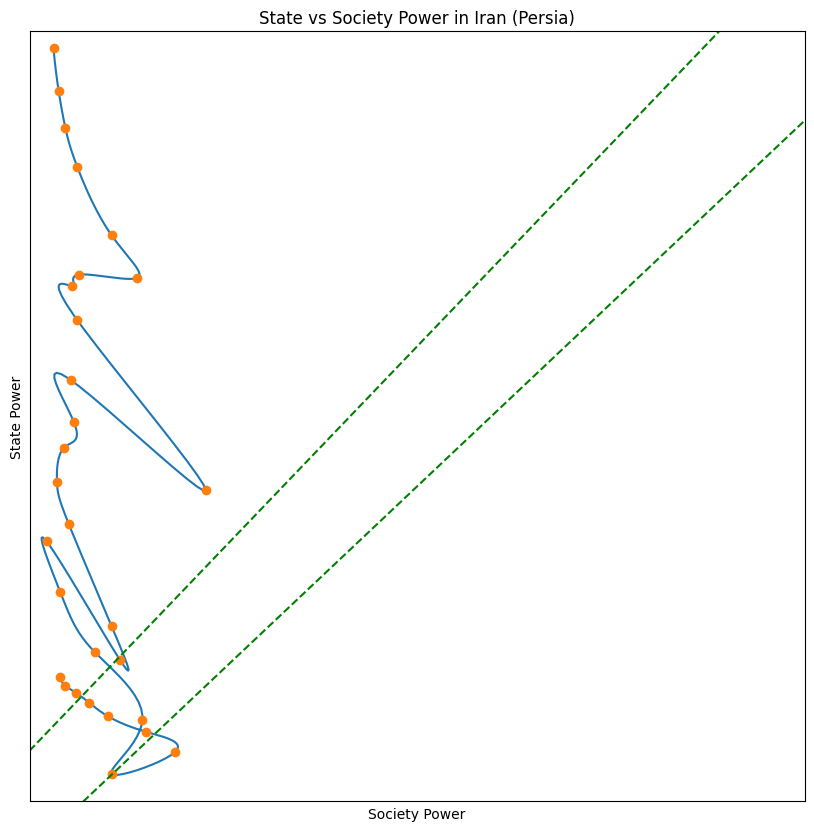

In [ ]:
# image_filename = os.path.join('drive/MyDrive/NarrowCorridorPath', f"{base_filename}.png")
image_filename = None
plot_path(path, image_filename)